<a href="https://colab.research.google.com/github/EnriqueSolarte/CNN-Architectures/blob/master/Implementations/AlexNet/AlexNet_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of AlexNet

We will use the [tensorflow.keras Functional API](https://www.tensorflow.org/guide/keras/functional) to build AlexNet from the original paper: “[ImageNet Classification with Deep Convolutional
Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)” by Alex Krizhevsky, Ilya Sutskever and Geoffrey E. Hinton.

[Video tutorial](https://www.youtube.com/watch?v=rFpzCPcI6O0&list=PLaPdEEY26UXyE3UchW0C742xh542yh0yI&index=1)

---

In the paper we can read:

>**[i]** “The ReLU non-linearity is applied to the output of every convolutional and fully-connected layer.”
>
>**[ii]** “We applied this normalization after applying the ReLU nonlinearity in certain layers.”
>
>**[iii]** “If we set s < z, we obtain overlapping pooling. This is what we use throughout our network, with s = 2 and z = 3.”
>
>**[iv]** “The first convolutional layer filters the 224×224×3 input image with 96 kernels of size 11×11×3 with a stride of 4 pixels (this is the distance between the receptive field centers of neighboring neurons in a kernel map)."
>
>**[v]** "The second convolutional layer takes as input the (response-normalized and pooled) output of the first convolutional layer and filters it with 256 kernels of size 5 × 5 × 48.
>
>**[vi]** "The third, fourth, and fifth convolutional layers are connected to one another without any intervening pooling or normalization layers. The third convolutional layer has 384 kernels of size 3 × 3 × 256 connected to the (normalized, pooled) outputs of the second convolutional layer.”
>
>**[vii]** ”The fourth convolutional layer has 384 kernels of size 3 × 3 × 192 , and the fifth convolutional layer has 256 kernels of size 3 × 3 × 192. The fully-connected layers have 4096 neurons each.”
>
>**[viii]** "We use dropout in the first two fully-connected layers [...]"

<br>

We will also use the following Diagram **[ix]**:

<img src=https://raw.githubusercontent.com/Machine-Learning-Tokyo/DL-workshop-series/master/Part%20I%20-%20Convolution%20Operations/images/AlexNet.png width="800">

---

## Network architecture

- The network consists of 5 *Convolutional* layers and 3 *Fully Connected* Layers (**[ix]**)

- *Max Pooling* is applied Between the layers:
 - 1conv-2conv (**[v]**)
 - 2conv-3conv (**[vi]**)
 - 5conv-1fc (**[ix]**)

- Before Max Pooling a normalization technique is applied. At the paper a normalization method named LRN (Local Response Normalization) was used. However, since LRN is not part of the standard *tensorflow.keras* library and it is not in the scope of this section to teach how to write custom layers, we will use another method instead. We chose to replace LRN with *Batch Normalization* for this example.

---

## Workflow
We will:
1. import the neccesary layers
2. demonstrate how tensors and tf.keras layers work 
3. write the code for the first block
4. write the code for the blocks 2-5 (*Convolution blocks*)
5. write the code for the hidden *Fully Connected blocks*
6. write the code for the output *Fully Connected blocks*
7. build the model

---

### 1. Imports

In [0]:
from tensorflow.keras.layers import Input, Conv2D, \
     BatchNormalization, MaxPool2D, Flatten, Dense, Dropout

### 2. *Tensors* and *Layers*
The idea is to build a graph of tensors which are connected through layers. We will start with the input tensor which is created by an `Input()` layer.

In the `Input()` layer we have to define the *shape* of the input object (e.g. a numpy array).

In [0]:
input = Input(shape=(224, 224, 3))

`input` is a tensorflow Tensor object:

In [0]:
type(input)

tensorflow.python.framework.ops.Tensor

### 3. 1st block
Now we can pass this tensor to another *layer* object and the output will be another tensor.

The first layer that we will apply is a *Convolutional* layer (`Conv2D()`)

In this layer we will pass:
- the number of filters
- the kernel size
- the strides
- the padding
- the activation function

From the paper:

>The first convolutional layer filters the 224×224×3 input image with **96 kernels** of size **11×11**×3 with a **stride of 4** pixels (**[iv]**)

>The **ReLU** non-linearity is applied to the output of every convolutional and fully-connected layer (**[i]**)

*Note: at each reference we mark with **bold** the parts that are informative for the coding of the corresponding block.*

In [0]:
x = Conv2D(filters=96,
          kernel_size=11,
          strides=4,
          padding='same',
          activation='relu')(input)  # 1st convolutional layer

Before the second Convolutional layer we have to normalize and pool the output of the first Convolutional layer:

> "The second convolutional layer takes as input the (**response-normalized and pooled**) output of the first convolutional layer" (**[v]**)

Regarding the `MaxPool2D()` layer we have to pass:

- the pool size
- the strides


From the paper:

>If we set s < z, we obtain overlapping pooling. This is what we use throughout our network, with **s = 2 and z = 3** (**[iii]**)

In [0]:
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=3, strides=2)(x)

Notice that it is ok to use the same name `x` for the output tensor of different layers as long as we implement with the correct order.

<br>

So the first block is now:

```python
x = Conv2D(filters=96,
          kernel_size=11,
          strides=4,
          padding='same',
          activation='relu')(input)  # 1st convolutional layer

x = BatchNormalization()(x)
x = MaxPool2D(pool_size=3, strides=2)(x)
```

### 4. 2nd-5th block

From the paper:

>The **second** convolutional layer takes as input the (response-normalized and pooled) output of the first convolutional layer and filters it with **256 kernels of size 5 × 5** × 48 (**[v]**)

*Note: The **48** as the size of the last dimension of the kernel is technically 96 in our case. This is because the input tensor has 96 feature maps, equal to the number of kernels of the previous layer. However, since the original network was implemented in two GPUs in parallel, each one had 48 feature maps at this stage.*

In [0]:
x = Conv2D(filters=256,
          kernel_size=5,
          padding='same',
          activation='relu')(x)  # 2nd convolutional layer

From the paper:

>The **third** convolutional layer has **384 kernels of size 3 × 3** × 256 connected to the (**normalized, pooled**) outputs of the second convolutional layer. (**[vi]**)

In [0]:
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=3, strides=2)(x)

x = Conv2D(filters=384,
          kernel_size=3,
          padding='same',
          activation='relu')(x)  # 3rd convolutional layer

From the paper:

>The **fourth** convolutional layer has **384 kernels of size 3 × 3** × 192 (**[vii]**)

In [0]:
x = Conv2D(filters=384,
          kernel_size=3,
          padding='same',
          activation='relu')(x)  # 4th convolutional layer

From the paper:

>the **fifth** convolutional layer has **256 kernels of size 3 × 3** × 192. (**[vii]**)

In [0]:
x = Conv2D(filters=256,
          kernel_size=3,
          padding='same',
          activation='relu')(x)  # 5th convolutional layer

x = BatchNormalization()(x)
x = MaxPool2D(pool_size=3, strides=2)(x)

### 5. Dense layers

Before passing the output tensor of the last Convolutional layer (13x13x256) to the first `Dense()` layer we have to flatten it to a one-dimension tensor. We do it by using the `Flatten()` layer.

*Note: you may find the (one-dimension) tensors to also be called vectors. We use the word tensor as reference to the tensorflow.Tensor object of which it is an instance.*

From the paper:

>The **fully-connected** layers have **4096** neurons each (**[vii]**)
>Dropout with drop probability 0.5 is used after the first 2 Fully Connected layers (**[viii]**)

In [0]:
x = Flatten()(x)
x = Dense(units=4096, activation='relu')(x)
x = Dense(units=4096, activation='relu')(x)
x = Dropout(rate=0.5)(x)

### 6. Output layer

Since the model is to be used for classifiction tasks, the output of the model will be a `Dense()` layer with:
- number of units equal to the number of classes in our task which are 1000 based on **[ix]**
- `softmax` actication if we target to only one class per image

In [0]:
output = Dense(units=1000, activation='softmax')(x)

### 7. Model

In order to build the *model* we will use the `tensorflow.keras.Model` object:

In [0]:
from tensorflow.keras import Model

To define the model we need the input tensor(s) and the output tensor(s).

In [0]:
model = Model(inputs=input, outputs=output)

## Final code

In [0]:
from tensorflow.keras.layers import Input, Conv2D, \
     BatchNormalization, MaxPool2D, Flatten, Dense, Dropout

input = Input(shape=(224, 224, 3))

x = Conv2D(filters=96,
           kernel_size=11,
           strides=4,
           padding='same',
           activation='relu')(input)  # 1st convolutional layer
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=3, strides=2)(x)

x = Conv2D(filters=256,
           kernel_size=5,
           padding='same',
           activation='relu')(x)  # 2nd convolutional layer
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=3, strides=2)(x)

x = Conv2D(filters=384,
           kernel_size=3,
           padding='same',
           activation='relu')(x)  # 3rd convolutional layer

x = Conv2D(filters=384,
           kernel_size=3,
           padding='same',
           activation='relu')(x)  # 4th convolutional layer

x = Conv2D(filters=256,
           kernel_size=3,
           padding='same',
           activation='relu')(x)  # 5th convolutional layer
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=3, strides=2)(x)

x = Flatten()(x)
x = Dense(units=4096, activation='relu')(x)
x = Dense(units=4096, activation='relu')(x)
x = Dropout(rate=0.5)(x)

output = Dense(units=1000, activation='softmax')(x)

from tensorflow.keras import Model

model = Model(inputs=input, outputs=output)



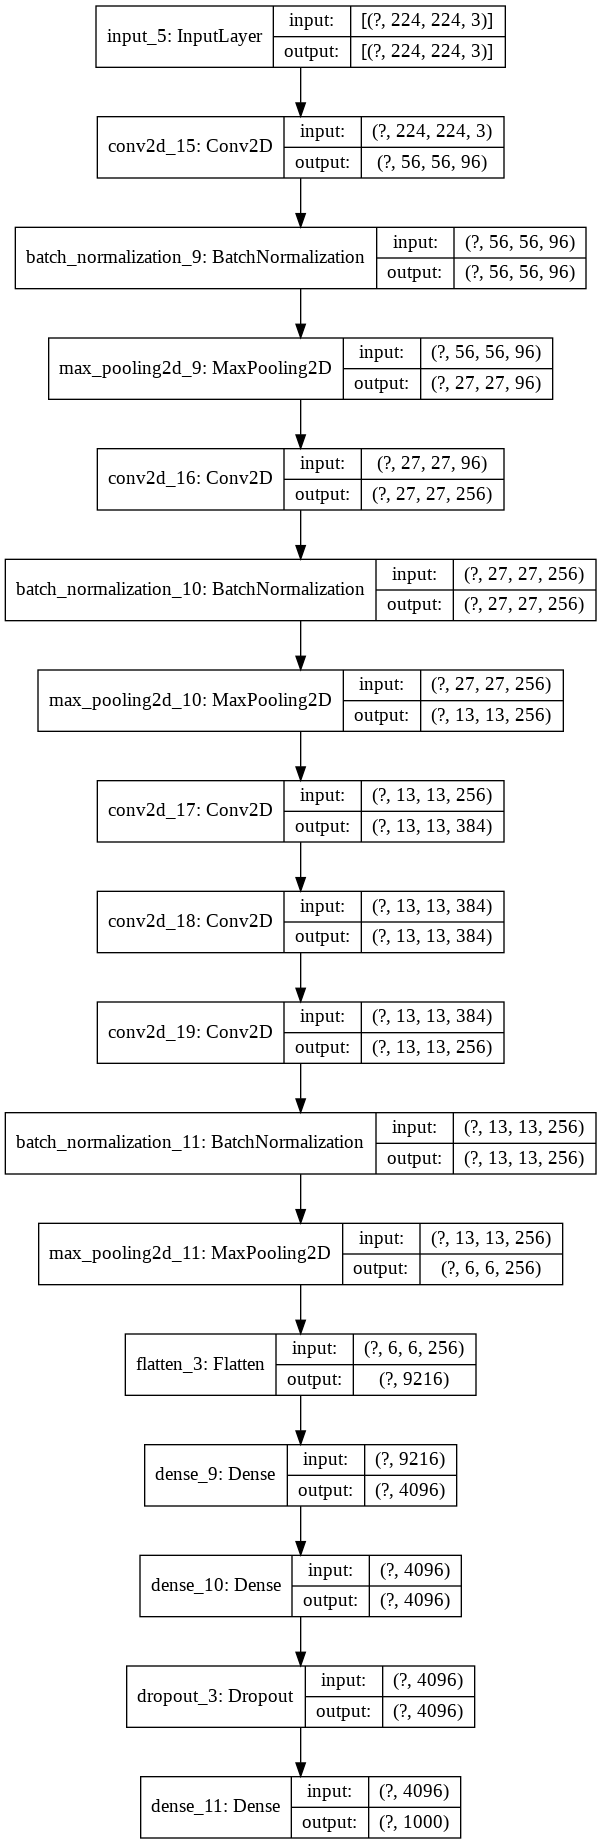

In [13]:
from tensorflow.keras.utils import  plot_model
plot_model(model , show_shapes=True)

## Model diagram

<img src="https://raw.githubusercontent.com/Machine-Learning-Tokyo/CNN-Architectures/master/Implementations/AlexNet/AlexNet_diagram.svg?sanitize=true">